# Running on a cluster

We'll use a Dask cluster in the cloud—in this case, using [Coiled](https://coiled.io/)—to use many machines to process the data in parallel. We can also run in a data center near* where the data is stored for better performance.

If you use Coiled (which is both easy to use, and currently free!), you can set `software="gjoseph92/stackstac"` to get a software environment where the latest version of `stackstac` is already installed.

In [1]:
import coiled
import distributed

cluster = coiled.Cluster(
    name="stackstac",
    software="gjoseph92/stackstac",
    backend_options={"region": "us-west-2"},
)
client = distributed.Client(cluster)
client

Using existing cluster: stackstac


<Client: 'tls://10.4.11.94:8786' processes=4 threads=16, memory=68.72 GB>

In [2]:
import stackstac
import satsearch

from rasterio.enums import Resampling

### Search for a full year of Sentinel-2 data over Santa Fe, New Mexico.

We'll look at 2019-2020.

In [3]:
%%time
items = satsearch.Search(
    url="https://earth-search.aws.element84.com/v0",
    intersects=dict(type="Point", coordinates=[-106, 35.7]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2019-01-01/2020-01-01"
).items()
len(items)

CPU times: user 84.8 ms, sys: 20.7 ms, total: 106 ms
Wall time: 3.09 s


294

### Set a coarser resolution to speed up the computation

We'll have `stackstac` retrieve the data at 100m resolution, instead of its native 10m.
Since the data is stored in [Cloud-Optimized GeoTIFFs](https://www.cogeo.org/) with internal overviews, fetching lower-resolution data is very efficient and requires processing an order of magnitude less data.

(Internally, `stackstac` is just telling rasterio/GDAL to build a VRT at this resolution. GDAL then automatically figures out which overview level to fetch data from.)

We also set `bounds_latlon` to just the area we want to look at (additionally, this drops any items that don't intersect that bounding box), and set the resampling method to bilinear to produce a nicer-looking image.

In [4]:
%%time
stack = stackstac.stack(
    items,
    resolution=100,
    bounds_latlon=[-106.2, 35.6, -105.6, 36],
    resampling=Resampling.bilinear
)

CPU times: user 205 ms, sys: 10.6 ms, total: 216 ms
Wall time: 215 ms


In [5]:
stack

<xarray.DataArray 'stackstac-ae169f4201b4c70e2f19d70d036371ff' (time: 294, band: 17, y: 450, x: 547)>
dask.array<fetch_raster_window, shape=(294, 17, 450, 547), dtype=float64, chunksize=(1, 1, 450, 547), chunktype=numpy.ndarray>
Coordinates: (12/23)
  * time                        (time) datetime64[ns] 2019-01-02T18:04:01 ......
    id                          (time) <U24 'S2A_13SDV_20190102_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 3.914e+05 3.914e+05 ... 4.46e+05
  * y                           (y) float64 3.985e+06 3.985e+06 ... 3.94e+06
    sentinel:sequence           (time) object None None None ... '0' '0' '0'
    ...                          ...
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20190102T175731_N0211...
    proj:epsg                   int64 32613
    view:off_nadir              int64 0
    sentinel:latitude_band      <U1 'S'
    created                     (time) <U24 '2020-09-23T19:20:47.956Z' ... '2...
    title                       (band) object None ... 'Scene Classification ...
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(391300, 3939700, 446000, 3984...
    crs:         epsg:32613
    transform:   | 100.00, 0.00, 391300.00|\n| 0.00,-100.00, 3984700.00|\n| 0...
    resolution:  100

For comparison, this is how much data we'd be processing if we'd used full 10m resolution:

In [6]:
import dask
dask.utils.format_bytes(stackstac.stack(items).nbytes)

'9.21 TB'

### Prepare monthly RGB composites

Now, use standard xarray methods to select out the red, green, and blue bands, then make monthly median composites.

In [7]:
rgb = stack.sel(band=["B04", "B03", "B02"])
monthly_rgb = rgb.resample(time="MS").median(dim="time")
monthly_rgb

<xarray.DataArray 'stackstac-ae169f4201b4c70e2f19d70d036371ff' (time: 12, band: 3, y: 450, x: 547)>
dask.array<stack, shape=(12, 3, 450, 547), dtype=float64, chunksize=(1, 2, 450, 547), chunktype=numpy.ndarray>
Coordinates:
  * time                    (time) datetime64[ns] 2019-01-01 ... 2019-12-01
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 3.914e+05 3.914e+05 ... 4.46e+05
  * y                       (y) float64 3.985e+06 3.985e+06 ... 3.94e+06
    constellation           <U10 'sentinel-2'
    instruments             <U3 'msi'
    gsd                     int64 10
    sentinel:utm_zone       int64 13
    proj:epsg               int64 32613
    view:off_nadir          int64 0
    sentinel:latitude_band  <U1 'S'
    title                   (band) object 'Band 4 (red)' ... 'Band 2 (blue)'

### Compute in parallel on the cluster

In [8]:
%time rgb_ = monthly_rgb.compute()

CPU times: user 1.29 s, sys: 273 ms, total: 1.56 s
Wall time: 2min 28s


Using 4 Coiled workers (4 CPU, 16 GiB memory each), we processed the ~10 GB of data into median composites in a couple minutes.

Go to the dashboard at https://cloud.coiled.io to watch the computation in progress.

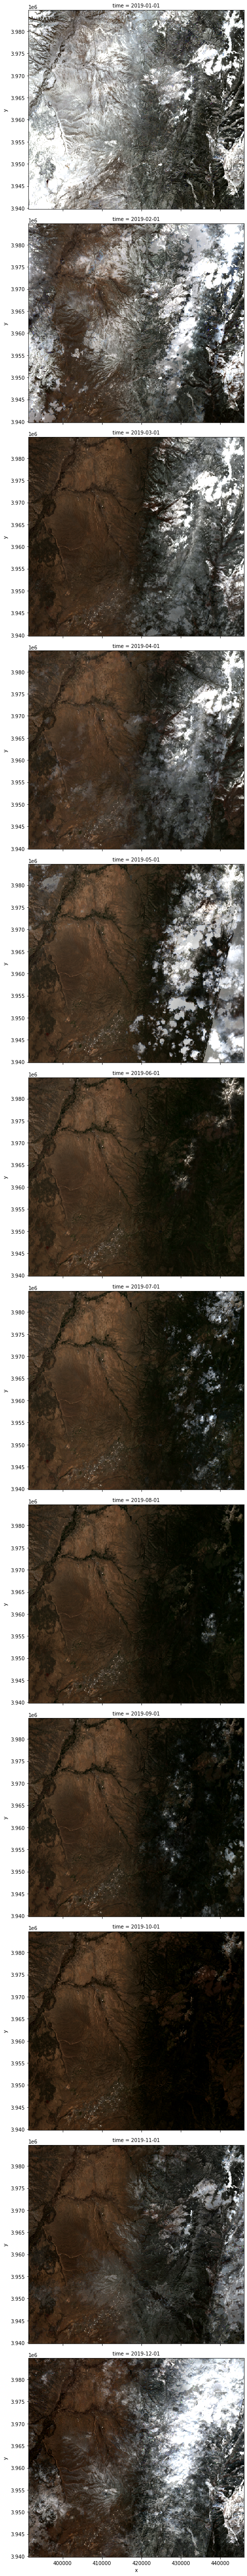

In [9]:
rgb_.plot.imshow(row="time", rgb="band", robust=True, size=6)

According to the Coiled dashboard, this cost about 74 cents. Was this picture worth 74 cents to you?